# Neural Style Transfer Using pystiche

\
> By Dr. An
\
> YouTube Channel: [Apply AI like a Pro](https://www.youtube.com/channel/UCmwd5_sW0vb5J38ShMVs0VQ)

\
The code used in this tutorial are adapted from [here](https://docs.pystiche.org/en/latest/galleries/examples/beginner/example_nst_with_pystiche.html#sphx-glr-galleries-examples-beginner-example-nst-with-pystiche-py).

\
Neural Style transfer (NST) is the task of changing the style of an image in one domain to the style of an image in another domain using deep neural network models. For example, you can transfer the photo of a night sky to a "Starry Night" Van Gogh style.

\
In NST, we have two images--***style*** and ***content***. We need to copy the style from the style image and apply it to the content image.

\
In this tutorial, we will use [pystiche](https://docs.pystiche.org/en/latest/index.html), a framework for NST built upon PyTorch.

In [ ]:
# Install the pystiche module.
! pip install pystiche --quiet

     |████████████████████████████████| 67 kB 4.7 MB/s 


In [ ]:
# Import modules
import os
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import pystiche
from pystiche import demo, enc, loss, optim
from pystiche.image import show_image
from pystiche.misc import get_device, get_input_image
from pystiche.image import read_image

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "


In [ ]:
# Get the multi-layer encoder (both the architecture as well as the pre-trained weights) 
# based on the VGG-19 model
multi_layer_encoder = enc.vgg19_multi_layer_encoder()
print(multi_layer_encoder)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGGMultiLayerEncoder(
  arch=vgg19, framework=torch
  (preprocessing): TorchPreprocessing(
    (0): Normalize(mean=('0.485', '0.456', '0.406'), std=('0.229', '0.224', '0.225'))
  )
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3

The core components of every NST are the ***content_loss*** and the ***style_loss***. Combined they make up the ***perceptual loss***, i.e. the optimization criterion.

\
We can use the FeatureReconstructionLoss() as content_loss. We first extract the content_encoder that generates encodings from the content_layer. Together with the content_weight we can construct the content_loss.

In [ ]:
# Extract the content layer from the multi-layer encoder
content_layer = "relu4_2"
content_encoder = multi_layer_encoder.extract_encoder(content_layer)

# Specify the content weight and construct the content loss
content_weight = 1
content_loss = loss.FeatureReconstructionLoss(
  content_encoder, 
  score_weight = content_weight)
print(content_loss)

FeatureReconstructionLoss(
  (encoder): VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
)


In [ ]:
# Specify the style weight and style layers.
style_weight = 1000
style_layers = ("relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1")

# We use the GramLoss as style_loss.
def get_style_op(encoder, layer_weight):
  return loss.GramLoss(encoder, score_weight = layer_weight)

# Unlike before, we use multiple style_layers. 
# The individual losses can be conveniently bundled in a MultiLayerEncodingLoss.
style_loss = loss.MultiLayerEncodingLoss(
  multi_layer_encoder, 
  style_layers, 
  get_style_op, 
  score_weight = style_weight)
print(style_loss)

MultiLayerEncodingLoss(
  encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
  (relu1_1): GramLoss(score_weight=0.2)
  (relu2_1): GramLoss(score_weight=0.2)
  (relu3_1): GramLoss(score_weight=0.2)
  (relu4_1): GramLoss(score_weight=0.2)
  (relu5_1): GramLoss(score_weight=0.2)
)


In [ ]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Define the perceptual loss, which combines the content loss and the style loss
perceptual_loss = loss.PerceptualLoss(content_loss, style_loss).to(device)
print(perceptual_loss)

PerceptualLoss(
  (content_loss): FeatureReconstructionLoss(
    (encoder): VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
  )
  (style_loss): MultiLayerEncodingLoss(
    encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
    (relu1_1): GramLoss(score_weight=0.2)
    (relu2_1): GramLoss(score_weight=0.2)
    (relu3_1): GramLoss(score_weight=0.2)
    (relu4_1): GramLoss(score_weight=0.2)
    (relu5_1): GramLoss(score_weight=0.2)
  )
)


In [ ]:
# Mount Google drive to Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the content image file using the read_image() function provided by pystiche
# The image is downloaded from:
# https://wallpapercrafter.com/155001-cityscape-big-ben-london-river-thames-river-sky-reflection.html
size = 1000
content_img = read_image(
  "/content/drive/MyDrive/DreamJarsAI/Datasets/bigben.jpg", 
  size = size, 
  device = device)

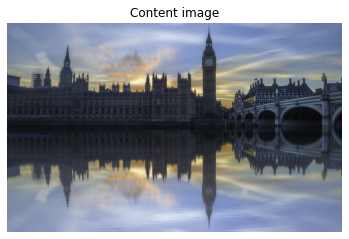

In [ ]:
# Use the show_image() function provided by pystiche to show the image
show_image(content_img, title = "Content image")

In [ ]:
# We download the style image, San Giorgio Maggiore at Dusk by Claude Monet, from Wikipedia:
# https://en.wikipedia.org/wiki/San_Giorgio_Maggiore_at_Dusk#/media/File:Claude_Monet,_Saint-Georges_majeur_au_cr%C3%A9puscule.jpg
style_img = read_image(
  "/content/drive/MyDrive/DreamJarsAI/Datasets/monet.jpg", 
  size = size, 
  device = device)

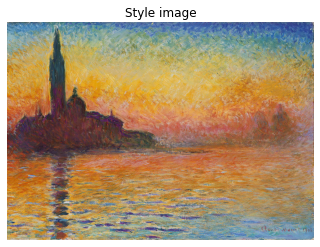

In [ ]:
# Use the show_image() function provided by pystiche to show the image
show_image(style_img, title = "Style image")

In [ ]:
# Set the content image and the style image as targets for the optimization criterion,
# namely the perceptual loss
perceptual_loss.set_content_image(content_img)
perceptual_loss.set_style_image(style_img)

In [ ]:
# As a last preliminary step we create the input image. 
# We start from the content image since this way the NST converges quickly.
# Note: To start from a white noise image instead, use starting_point = "random"
starting_point = "content"
input_image = get_input_image(
  starting_point, 
  content_image = content_img)

In [ ]:
# Minimize the perceptual loss.
# In every step, the perceptual_loss is calculated and backpropagated to the pixels of the input_image.
output_image = optim.image_optimization(
  input_image, 
  perceptual_loss, 
  num_steps = 500)

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

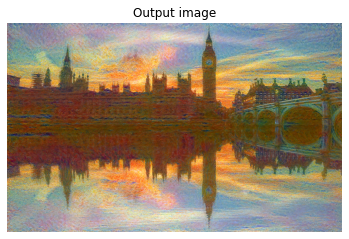

In [ ]:
# Show the output image after NST
show_image(
  output_image, 
  title = "Output image")